Tenemos la función
$$F(X) = \sum_{(i,j) \in \Omega}(x_{ij} - x_{ij}^*)^2$$
Y entonces su gradiente viene dado por
$$\nabla F(X)_{ij} =
\begin{cases}
2(x_{ij} - x_{ij}^*) & \text{si } (i,j) \in \Omega \\
0 & \text{si } (i,j) \notin \Omega
\end{cases}$$
Esto es, en notación matricial
$$\nabla F(X) = 2\, \mathcal{P}_\Omega(X - X^*)$$
donde $\mathcal{P}_\Omega$ es el operador de proyección que mantiene solo las coordenadas en $\Omega$ y pone ceros en el resto.
Para calcular su constante de suavidad, tenemos que encontrar $L$ tal que
$$\|\nabla F(X) - \nabla F(Y)\|_{F, *} \leq L\|X - Y\|_F$$
Pero como estamos trabajando con la norma de Frobenius, que es una norma euclidiana, se cumple que su norma dual coincide consigo misma. Por lo tanto, queremos que
$$\|\nabla F(X) - \nabla F(Y)\|_F \leq L\|X - Y\|_F$$
A partir del gradiente obtenido, tenemos
$$\nabla F(X) - \nabla F(Y) = 2\, \mathcal{P}_\Omega(X - Y)$$
Por lo tanto
$$\|\nabla F(X) - \nabla F(Y)\|_F = 2\|\mathcal{P}_\Omega(X - Y)\|_F \leq 2\|X - Y\|_F$$
ya que la proyección $\mathcal{P}_\Omega$ no puede aumentar la norma por desigualdad triangular.
Concluimos entonces que una constante de suavidad válida es
$$L = 2$$


Ahora que ya vimos toda la parte teórica, vamos con la implementación. Comencemos por importar las librerías necesarias

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from time import time
from sklearn.model_selection import train_test_split
from scipy.linalg import svd
from scipy.sparse.linalg import svds

Ahora implementemos la función de proyección, simplemente la voy a implementar porque ya la discutí suficente en la parte teórica de la tarea

In [30]:
def proyl1(x, R):
    if np.linalg.norm(x, 1) <= R:
        return x
    xp = np.flip(np.sort(abs(x)))
    S = np.cumsum(xp)
    Rx = S - (np.arange(len(S)) + 1)*xp
    k = np.max(np.where(Rx <= R))
    Lambda = (S[k] - R)/(k+1)
    z = np.sign(x)*np.maximum(np.abs(x) - Lambda, 0)
    return z

def proynuc(X, R):
    U, Sigma, Vt = svd(X, full_matrices=False)
    Ytilde = proyl1(Sigma, R)
    Y = U @ np.diag(Ytilde) @ Vt
    return Y

Ahora implementemos el método del gradiente proyectado

In [31]:
def F(X, Xstar, Omega):
    return np.linalg.norm(Omega*(X - Xstar))**2

def Fgrad(X, Xstar, Omega):
    return 2*Omega*(X - Xstar)

def GradientMethod(X0, Xstar, Omega, R, eta = 0.5, MAXITERS = 100, MAXTIME = 600, delta = 1e-6):
    X = X0.copy()
    iters = 0
    timestart = time()
    
    while True:
        grad = Fgrad(X, Xstar, Omega)
        if np.linalg.norm(grad) < delta or iters == MAXITERS:
            break
        if time() - timestart > MAXTIME:
            raise(f"Tiempo máximo ({MAXTIME}s) alcanzado")
        X = proynuc(X - eta*grad, R)
        iters += 1
        
    return X

Y también implementemos la versión con backtracking

In [32]:
def BacktrackingGradientMethod(X0, Xstar, Omega, R, MAXITERS = 100, MAXTIME = 600, delta = 1e-6):
    X = X0.copy()
    eta = 1
    beta = 0.5
    iters = 0
    timestart = time()
    
    while True:
        grad = Fgrad(X, Xstar, Omega)
        if np.linalg.norm(grad) < delta or iters == MAXITERS:
            break
        if time() - timestart > MAXTIME:
            raise(f"Tiempo máximo ({MAXTIME}s) alcanzado")
        vX = F(X, Xstar, Omega)
        while True:
            Xnew = X - eta*grad
            vXnew = F(Xnew, Xstar, Omega)
            if vXnew <= vX - eta/2*np.linalg.norm(grad)**2 or eta < 1e-18:
                X = proynuc(Xnew, R)
                break
            else:
                eta = beta*eta
        iters += 1
        
    return X

Y finalmente implementemos el método del gradiente condicional

In [60]:
def argminPt(X, Xstar, Omega, R):
    grad = Fgrad(X, Xstar, Omega)
    U, s, Vt = svds(-grad, 1)
    u, v = U[0], Vt[0]
    return R*np.outer(u, v)

def ConditionalGradientMethod(X0, Xstar, Omega, R, MAXITERS = 100, MAXTIME = 600):
    X = X0.copy()
    iters = 0
    timestart = time()
    
    while True:
        if iters == MAXITERS:
            break
        if time() - timestart > MAXTIME:
            raise(f"Tiempo máximo ({MAXTIME}s) alcanzado")
        V = argminPt(X, Xstar, Omega, R)
        eta = 2/(iters + 2)
        X = (1-eta)*X + eta*V
        iters += 1

    return X

Ahora probemos los métodos, para esto consideremos el código para generar matrices de bajo rango propuesto en el enunciado

In [53]:
np.random.seed(47)
rank = 10
users, movies = 1000, 500
# Generate random low-rank matrices U and V
U = np.random.rand(users, rank)
V = np.random.rand(rank, movies)
# Compute the product to get the low-rank matrix X
Full_Data = np.dot(U, V)
ratings_fraction = 0.1
Mask_Train = np.random.binomial(1, ratings_fraction, size=(users, movies))
Masked_Train_Data = np.multiply(Full_Data, Mask_Train)
Mask_Validation = np.random.binomial(1, ratings_fraction, size =(users,movies))
Masked_Validation_Data = np.multiply(Full_Data, Mask_Validation)

Y ahora probemos los modelos. Notemos que cambie el rango de $R$ a $R = 2^i$ para $i \in \{8, 9, 10, 11, 12\}$ puesto que de una exploración inicial (y calculando la norma nuclear de la matriz completa) se ve que este es un mejor rango para encontrar $R$. Primero implementemos una función para calcular el error

In [54]:
def Error(X, Xstar, Omega):
    return F(X, Xstar, Omega)/np.linalg.norm(Xstar)**2

Y ahora veamos los resultados

In [61]:
X0 = np.zeros_like(Full_Data)

for j in range(8, 13):
    R = 2**j
    print(f"Entrenando para R = {R}")
    
    timestart = time()
    Xhat = GradientMethod(X0, Masked_Train_Data, Mask_Train, R)
    tiempo = time() - timestart
    errort = Error(Xhat, Masked_Train_Data, Mask_Train)
    errorv = Error(Xhat, Masked_Validation_Data, Mask_Validation)
    print(f"El método del gradiente se tardó {tiempo:.4f}s y tuvo un errores relativos de {errort:.4f} (train) y {errorv:.4f} (val)")
    
    timestart = time()
    Xhat = BacktrackingGradientMethod(X0, Masked_Train_Data, Mask_Train, R)
    tiempo = time() - timestart
    errort = Error(Xhat, Masked_Train_Data, Mask_Train)
    errorv = Error(Xhat, Masked_Validation_Data, Mask_Validation)
    print(f"El método del gradiente con backtracking se tardó {tiempo:.4f}s y tuvo un errores relativos de {errort:.4f} (train) y {errorv:.4f} (val)")
    
    timestart = time()
    Xhat = ConditionalGradientMethod(X0, Masked_Train_Data, Mask_Train, R)
    tiempo = time() - timestart
    errort = Error(Xhat, Masked_Train_Data, Mask_Train)
    errorv = Error(Xhat, Masked_Validation_Data, Mask_Validation)
    print(f"El método del gradiente condicional se tardó {tiempo:.4f}s y tuvo un errores relativos de {errort:.4f} (train) y {errorv:.4f} (val)")
    
    print()


Entrenando para R = 256
El método del gradiente se tardó 20.9989s y tuvo un errores relativos de 0.7359 (train) y 0.7417 (val)
El método del gradiente con backtracking se tardó 21.2437s y tuvo un errores relativos de 0.7359 (train) y 0.7417 (val)
El método del gradiente condicional se tardó 2.0486s y tuvo un errores relativos de 0.6921 (train) y 0.6941 (val)

Entrenando para R = 512
El método del gradiente se tardó 19.3920s y tuvo un errores relativos de 0.5135 (train) y 0.5215 (val)
El método del gradiente con backtracking se tardó 19.8321s y tuvo un errores relativos de 0.5135 (train) y 0.5215 (val)
El método del gradiente condicional se tardó 2.2468s y tuvo un errores relativos de 0.4374 (train) y 0.4400 (val)

Entrenando para R = 1024
El método del gradiente se tardó 18.7047s y tuvo un errores relativos de 0.1918 (train) y 0.1978 (val)
El método del gradiente con backtracking se tardó 19.1830s y tuvo un errores relativos de 0.1918 (train) y 0.1978 (val)
El método del gradiente cond

Notemos que el mejor $R$ se alcanzó cuando $R = 2048$. Además podemos notar que el método del gradiente condicional hace 100 iteraciones mucho más rápido que los otros métodos y que incluso las iteraciones son de mejor calidad puesto que consigue un error menor que los otros métodos (excepto con $R$ muy cerca de la norma nuclear de la matriz original y salvo errores de sobreajuste, esto se debe a como está implementado svds con el método de Lanczos, ya que en esos casos el problema queda mal condicionado y trae errores sobre este método). Otra observación es que el método del gradiente y el método del gradiente con backtracking funcionan similar, esto se debe a que pudimos encontrar explícitamente el valor de la constante de suavidad, por lo que pudimos configurar un buen $\eta$ fijo para el primer método. En conclusión, el método del gradiente condicional es superior a los otros en todos los aspectos.

Ahora vamos con las bases de datos reales. Implementemos una función para leer los datos. Voy a dividirlos con una función de python ya que no me funcionó el código proporcionado por la librería.

In [62]:
def cargardatos(url, se = '::', url2 = None):
    
    ratingstrain = pd.read_csv(url, sep=se, names = ['user_id', 'item_id', 'rating', 'timestamp'])
    n_users = np.max(ratingstrain['user_id'])
    n_items = np.max(ratingstrain['item_id'])
    
    if se == ',':
        ratingstrain = ratingstrain.drop(index=0)
    if url2 == None:
        ratingstrain, ratingsval = train_test_split(ratingstrain, test_size=0.2, random_state=33)
    else:
        ratingsval = pd.read_csv(url2, sep=se, names = ['user_id', 'item_id', 'rating', 'timestamp'])
    
    Xtrain = np.zeros((n_users, n_items))
    Omegatrain = np.zeros((n_users, n_items))
    Xval = np.zeros((n_users, n_items))
    Omegaval = np.zeros((n_users, n_items))
    
    for row in ratingstrain.itertuples():
        Xtrain[row.user_id - 1, row.item_id - 1] = row.rating
        Omegatrain[row.user_id - 1, row.item_id - 1] = 1
    
    for row in ratingsval.itertuples():
        Xval[row.user_id - 1, row.item_id - 1] = row.rating
        Omegaval[row.user_id - 1, row.item_id - 1] = 1
        
    X0 = np.zeros_like(Xtrain)    
    
    return X0, Xtrain, Omegatrain, Xval, Omegaval

Y ahora probemos con la base de datos, comencemos con la de 100k

In [66]:
X0, Xtrain, Omegatrain, Xval, Omegaval = cargardatos('u1.base', '\t', 'u1.test')

for j in range(8, 14):
    R = 2**j
    timestart = time()
    Xhat = ConditionalGradientMethod(X0, Xtrain, Omegatrain, R)
    tiempo = time() - timestart
    errort = Error(Xhat, Xtrain, Omegatrain)
    errorv = Error(Xhat, Xval, Omegaval)
    print(f"Para R = {R} se tardó {tiempo:.4f}s y tuvo un errores relativos de {errort:.4f} (train) y {errorv:.4f} (val)")

Para R = 256 se tardó 6.1327s y tuvo un errores relativos de 0.7870 (train) y 0.7901 (val)
Para R = 512 se tardó 6.1581s y tuvo un errores relativos de 0.6105 (train) y 0.6154 (val)
Para R = 1024 se tardó 6.4997s y tuvo un errores relativos de 0.3501 (train) y 0.3562 (val)
Para R = 2048 se tardó 6.1821s y tuvo un errores relativos de 0.1197 (train) y 0.1241 (val)
Para R = 4096 se tardó 7.0720s y tuvo un errores relativos de 0.1118 (train) y 0.1156 (val)
Para R = 8192 se tardó 7.7802s y tuvo un errores relativos de 0.1045 (train) y 0.1084 (val)


Podemos notar que el método funcionó super rápido y obtuvo buenos errores relativos. Notemos que el mejor valor para $R$ debe ser cercano a $2048$ ya que al crecer más no mejora el error. Ahora probémoslo con la base de datos de 1M

In [67]:
X0, Xtrain, Omegatrain, Xval, Omegaval = cargardatos('ml-1m/ratings.dat')

for j in range(8, 14):
    R = 2**j
    timestart = time()
    Xhat = ConditionalGradientMethod(X0, Xtrain, Omegatrain, R)
    tiempo = time() - timestart
    errort = Error(Xhat, Xtrain, Omegatrain)
    errorv = Error(Xhat, Xval, Omegaval)
    print(f"Para R = {R} se tardó {tiempo:.4f}s y tuvo un errores relativos de {errort:.4f} (train) y {errorv:.4f} (val)")

C:\Users\visoo\AppData\Local\Temp\ipykernel_9796\951058317.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  ratingstrain = pd.read_csv(url, sep=se, names = ['user_id', 'item_id', 'rating', 'timestamp'])


Para R = 256 se tardó 98.3150s y tuvo un errores relativos de 0.9797 (train) y 0.9797 (val)


MemoryError: Unable to allocate 182. MiB for an array with shape (6040, 3952) and data type float64

Y para este caso tampoco se estaba demorando demasiado (la primera vez corrió en un tiempo razonable) pero no tengo mucha RAM así que falló que me quedé sin memoria. Realmente debería tener esos 182MB pero me está dando problemas todo el rato y realmente no se por qué. Ahora probemos con la de 10M

In [68]:
X0, Xtrain, Omegatrain, Xval, Omegaval = cargardatos('ml-10M100K/ratings.dat')

for j in range(8, 14):
    R = 2**j
    timestart = time()
    Xhat = ConditionalGradientMethod(X0, Xtrain, Omegatrain, R)
    tiempo = time() - timestart
    errort = Error(Xhat, Xtrain, Omegatrain)
    errorv = Error(Xhat, Xval, Omegaval)
    print(f"Para R = {R} se tardó {tiempo:.4f}s y tuvo un errores relativos de {errort:.4f} (train) y {errorv:.4f} (val)")

C:\Users\visoo\AppData\Local\Temp\ipykernel_9796\951058317.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  ratingstrain = pd.read_csv(url, sep=se, names = ['user_id', 'item_id', 'rating', 'timestamp'])


MemoryError: Unable to allocate 34.7 GiB for an array with shape (71567, 65133) and data type float64

Nuevamente me quedé sin memoria. Y probemos con la de 20M

In [ ]:
X0, Xtrain, Omegatrain, Xval, Omegaval = cargardatos('ml-20m/ratings.csv', se = ',')

for j in range(8, 14):
    R = 2**j
    timestart = time()
    Xhat = ConditionalGradientMethod(X0, Xtrain, Omegatrain, R)
    tiempo = time() - timestart
    errort = Error(Xhat, Xtrain, Omegatrain)
    errorv = Error(Xhat, Xval, Omegaval)
    print(f"Para R = {R} se tardó {tiempo:.4f}s y tuvo un errores relativos de {errort:.4f} (train) y {errorv:.4f} (val)")

MemoryError: Unable to allocate 153. MiB for an array with shape (20000264,) and data type object

Y nuevamente me quedé sin memoria, ahora ni siquiera pude leer los datos de forma sparse.

Ahora agreguemos a las funciones anteriores una forma de poder ver el progreso. Para esto, voy a considerar guardar los tiempos de cada iteración y el error de validación. Además de considerar correr el algoritmo durante un tiempo fijo de un minuto. El resto de la implementación es igual a lo que ya habíamos hecho.

In [25]:
def TGradientMethod(X0, Xtrain, Omegatrain, Xval, Omegaval, R, MAXTIME = 60):
    X = X0.copy()
    eta = 0.5
    timestart = time()
    tiempos = [0]
    errores = [1]
    
    while time() - timestart <= MAXTIME:
        grad = Fgrad(X, Xtrain, Omegatrain)
        X = proynuc(X - eta*grad, R)
        tiempos.append(time() - timestart)
        errores.append(Error(X, Xval, Omegaval))
        
    return tiempos, errores

def TBacktrackingGradientMethod(X0, Xtrain, Omegatrain, Xval, Omegaval, R, MAXTIME = 60):
    X = X0.copy()
    eta = 1
    beta = 0.5
    timestart = time()
    tiempos = [0]
    errores = [1]
    
    while time() - timestart <= MAXTIME:
        grad = Fgrad(X, Xtrain, Omegatrain)
        vX = F(X, Xtrain, Omegatrain)
        while True:
            Xnew = X - eta*grad
            vXnew = F(Xnew, Xtrain, Omegatrain)
            if vXnew <= vX - eta/2*np.linalg.norm(grad)**2 or eta < 1e-18:
                X = proynuc(Xnew, R)
                break
            else:
                eta = beta*eta
        tiempos.append(time() - timestart)
        errores.append(Error(X, Xval, Omegaval))
        
    return tiempos, errores

def TConditionalGradientMethod(X0, Xtrain, Omegatrain, Xval, Omegaval, R, MAXTIME = 60):
    X = X0.copy()
    timestart = time()
    tiempos = [0]
    errores = [1]
    iters = 0
    
    while time() - timestart <= MAXTIME:
        V = argminPt(X, Xtrain, Omegatrain, R)
        eta = 2/(iters + 2)
        X = (1-eta)*X + eta*V
        tiempos.append(time() - timestart)
        errores.append(Error(X, Xval, Omegaval))
        iters += 1
        
    return tiempos, errores

Y ahora podemos obtener las estadísticas de los métodos para poder graficarlos y hacer una comparativa. Lo voy a probar con la base de datos de 100k ya que es la única que pude hacer funcionar. Además consideremos $R = 2048$ ya que ahí se alcanza el mejor valor, puesto que es el primero en conseguir un valor bajo (como el método de gradiente condicional no se sobreajusta por más que subamos el $R$ sigue encontrando algo bueno).

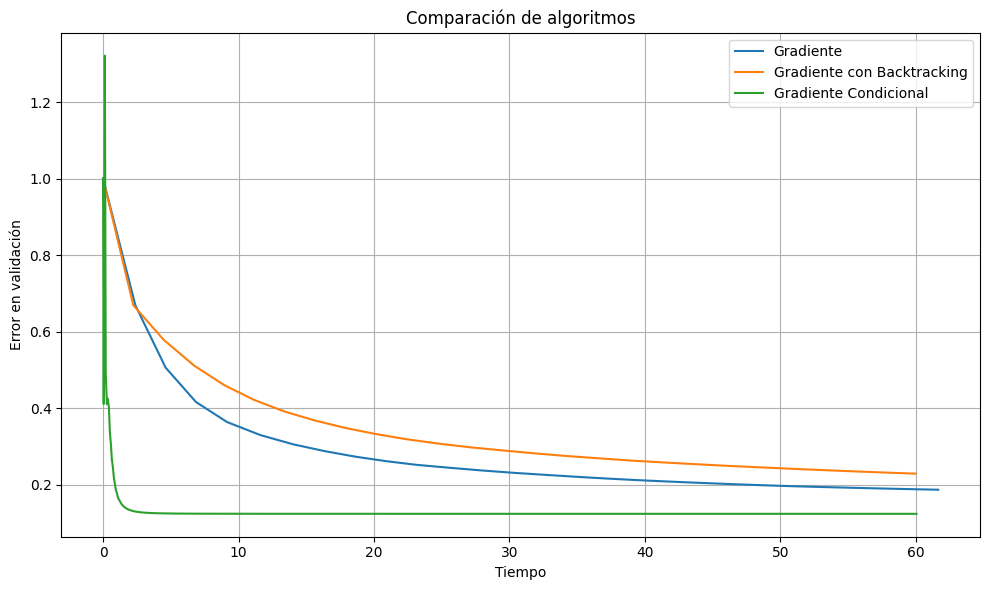

In [26]:
X0, Xtrain, Omegatrain, Xval, Omegaval = cargardatos('u1.base', '\t', 'u1.test')

tiempos_gd, errores_gd = TGradientMethod(X0, Xtrain, Omegatrain, Xval, Omegaval, 2048)
tiempos_bgd, errores_bgd = TBacktrackingGradientMethod(X0, Xtrain, Omegatrain, Xval, Omegaval, 2048)
tiempos_cg, errores_cg = TConditionalGradientMethod(X0, Xtrain, Omegatrain, Xval, Omegaval, 2048)

plt.figure(figsize=(10, 6))
plt.plot(tiempos_gd, errores_gd, label='Gradiente')
plt.plot(tiempos_bgd, errores_bgd, label='Gradiente con Backtracking')
plt.plot(tiempos_cg, errores_cg, label='Gradiente Condicional')

plt.xlabel('Tiempo')
plt.ylabel('Error en validación')
plt.title('Comparación de algoritmos')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Podemos ver que el método del gradiente condicional converge demasiado rápido. Incluso en 3 segundos consigue un mejor error que el resto de modelos en todo un minuto. Concluímos que este método es demasiado superior a los otros dos, al menos para esta tarea que se puede resolver $P_t$ fácilmente.